In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


def create_dataframe():
    # Initialize db connection and session
    db_engine, db_session = init_db()

    # Query data from the database
    query = db_session.query(
        RacingWeekend.year,
        RacingWeekend.round,
        Circuit.circuit_name,
        Driver.driver_name,
        Driver.driver_short,
        Lap.lap_num,
        Lap.lap_time,
        Lap.tyre,
        Lap.tyre_laps,
        Lap.pit,
        Session.session_type
    ).join(RacingWeekend.circuit) \
     .join(RacingWeekend.sessions) \
     .join(Session.laps) \
     .join(Lap.driver) \
     .join(RacingWeekend.season) \
     .all()

    # Convert result to list of dicts
    data = []
    for row in query:
        data.append({
            'year': row.year,
            'round': row.round,
            'circuit_name': row.circuit_name,
            'driver_name': row.driver_name,
            'driver_short': row.driver_short,
            'lap_num': row.lap_num,
            'lap_time': row.lap_time,
            'tyre': row.tyre,
            'tyre_laps': row.tyre_laps,
            'pit': row.pit,
            'session_type': row.session_type
        })

    # Create DataFrame
    df = pd.DataFrame(data)
    return df


def correct_fuel_effect(df, year, race_round, max_fuel_kg=110, fuel_effect_per_kg=0.03):
    # Adjust lap times in a race for the effect of fuel weight
    race_df = df[(df['year'] == year) & (df['round'] == race_round) & (df['session_type'] == "Race")].copy()
    max_laps = race_df['lap_num'].max()
    race_df['fuel_weight'] = max_fuel_kg - (race_df['lap_num'] - 1) * (max_fuel_kg / max_laps)
    race_df['fuel_correction'] = race_df['fuel_weight'] * fuel_effect_per_kg
    race_df['fuel_corrected_lap_time'] = race_df['lap_time'] - race_df['fuel_correction']
    return race_df


def assign_stint_numbers(df):
    # Assign stint numbers to laps based on pit stops for each driver
    df['stint'] = np.nan
    for driver in df['driver_short'].unique():
        driver_data = df[df['driver_short'] == driver]
        stint_number = 1
        for i in driver_data.index:
            if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
                stint_number += 1
            df.loc[i, 'stint'] = stint_number
    df['stint'] = df['stint'].astype(int)
    return df




def analyze_and_average_polynomials(df, driver, current_year, current_round):
    # Filter data for the specific race and driver
    race_df = df[(df['year'] == current_year) & (df['round'] == current_round) & (df['driver_short'] == driver)].copy()
    
    # Correct for fuel effect
    race_df = correct_fuel_effect(race_df, current_year, current_round)
    
    # Normalize lap times based on the fastest lap and filter out outliers
    fastest_lap_time = race_df['fuel_corrected_lap_time'].min()
    race_df = race_df[race_df['fuel_corrected_lap_time'] <= 1.03 * fastest_lap_time]  # Filter out lap times more than 3% slower
    
    # Calculate the difference from the fastest lap for each lap
    race_df['time_diff'] = race_df['fuel_corrected_lap_time'] - fastest_lap_time
    
    # Assign stint numbers
    race_df = assign_stint_numbers(race_df)
    
    # Store polynomial coefficients for each tyre type
    tyre_poly_coeffs = {tyre: [] for tyre in race_df['tyre'].unique()}
    
    # Loop over each tyre type and perform polynomial regression for each stint
    for tyre in race_df['tyre'].unique():
        tyre_data = race_df[race_df['tyre'] == tyre]
        
        # Loop through each stint for the given tyre type
        for stint in tyre_data['stint'].unique():
            stint_data = tyre_data[tyre_data['stint'] == stint]
            x = stint_data['lap_num']
            y = stint_data['time_diff']
            
            # Polynomial regression (2nd degree)
            if len(x) > 2:
                poly_coeffs = np.polyfit(x, y, 2)
                tyre_poly_coeffs[tyre].append(poly_coeffs)
    
    # Average the polynomial coefficients for each tyre type across stints
    averaged_poly_coeffs = {}
    for tyre, poly_coeffs_list in tyre_poly_coeffs.items():
        if poly_coeffs_list:
            avg_poly_coeffs = np.mean(poly_coeffs_list, axis=0)
            averaged_poly_coeffs[tyre] = avg_poly_coeffs
    
    # Return the averaged polynomial equations for each tyre type
    polynomial_equations = {}
    for tyre, coeffs in averaged_poly_coeffs.items():
        equation = f"{coeffs[0]:.8f}x^2 + {coeffs[1]:.8f}x + {coeffs[2]:.8f}"
        polynomial_equations[tyre] = equation
    
    return polynomial_equations


# Example usage
df = create_dataframe()

# Define the year and round
year = 2019
round_ = 1

# Get the list of drivers who participated in the race
race_drivers = df[(df['year'] == year) & (df['round'] == round_) & (df['session_type'] == 'Race')]['driver_short'].unique()

# Loop through each driver and calculate their polynomial equations
for driver in race_drivers:
    print(f"Calculating polynomial equations for driver: {driver}")
    
    # Analyze and average polynomials for the driver
    polynomial_equations = analyze_and_average_polynomials(df, driver=driver, current_year=year, current_round=round_)
    
    # Print the polynomial equations for each tire type
    for tyre, equation in polynomial_equations.items():
        print(f"  Tyre: {tyre}, Equation: {equation}")
    
    print("\n")  # Add a newline for readability
    
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_colwidth', None)  # Display full content of cells
pd.set_option('display.width', None)  # Auto-detect the display width
# df[df["session_type"]=="Race"].head(100)

Calculating polynomial equations for driver: GAS
  Tyre: 2, Equation: 0.00312947x^2 + -0.14760666x + 2.90176433
  Tyre: 1, Equation: -0.00642704x^2 + 0.70950880x + -17.53238408


Calculating polynomial equations for driver: PER
  Tyre: 1, Equation: 0.01190559x^2 + -0.19548358x + 1.72608421
  Tyre: 3, Equation: 0.00126997x^2 + -0.06099489x + 1.27020479


Calculating polynomial equations for driver: LEC
  Tyre: 1, Equation: 0.00205389x^2 + -0.05141167x + 1.51923778
  Tyre: 3, Equation: -0.00133901x^2 + 0.15500415x + -2.91247644


Calculating polynomial equations for driver: STR
  Tyre: 2, Equation: 0.00224325x^2 + -0.13260835x + 3.21470446
  Tyre: 3, Equation: -0.00434921x^2 + 0.41494598x + -7.80895793


Calculating polynomial equations for driver: MAG
  Tyre: 1, Equation: 0.00397028x^2 + -0.00167513x + 0.97105203
  Tyre: 2, Equation: 0.00055909x^2 + -0.01142998x + 0.81054228


Calculating polynomial equations for driver: ALB
  Tyre: 1, Equation: 0.00841234x^2 + -0.12053858x + 1.24125184

Selected Race: 2022 Round 11, Driver: ZHO


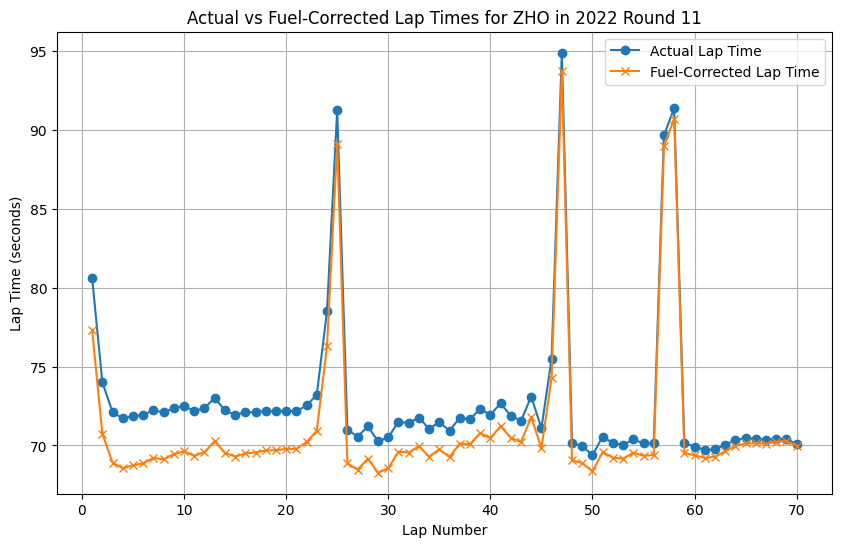

In [25]:
import matplotlib.pyplot as plt
import random

# Function to plot actual vs fuel-corrected lap times
def plot_fuel_corrected_vs_actual(df, year, round_, driver):
    # Apply fuel correction
    race_df = correct_fuel_effect(df, year, round_)
    
    # Filter for the specific driver
    driver_df = race_df[race_df['driver_short'] == driver]
    
    # Plot actual vs fuel-corrected lap times
    plt.figure(figsize=(10, 6))
    plt.plot(driver_df['lap_num'], driver_df['lap_time'], label='Actual Lap Time', marker='o')
    plt.plot(driver_df['lap_num'], driver_df['fuel_corrected_lap_time'], label='Fuel-Corrected Lap Time', marker='x')
    
    # Add labels and title
    plt.xlabel('Lap Number')
    plt.ylabel('Lap Time (seconds)')
    plt.title(f'Actual vs Fuel-Corrected Lap Times for {driver} in {year} Round {round_}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Select a random race and driver
def select_random_race_and_driver(df):
    # Get unique races
    unique_races = df[['year', 'round']].drop_duplicates()
    
    # Select a random race
    random_race = unique_races.sample(1).iloc[0]
    year = random_race['year']
    round_ = random_race['round']
    
    # Get drivers in the selected race
    drivers_in_race = df[(df['year'] == year) & (df['round'] == round_)]['driver_short'].unique()
    
    # Select a random driver
    driver = random.choice(drivers_in_race)
    
    return year, round_, driver

# Example usage
df = create_dataframe()

# Select a random race and driver
year, round_, driver = select_random_race_and_driver(df)
print(f"Selected Race: {year} Round {round_}, Driver: {driver}")

# Plot actual vs fuel-corrected lap times
plot_fuel_corrected_vs_actual(df, year, round_, driver)

Selected Race: 2023 Round 15, Driver: NOR


/tmp/ipykernel_56940/3455375743.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_df['delta_lap_time'] = driver_df['lap_time'] - fastest_lap_time
/tmp/ipykernel_56940/3455375743.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_df['delta_fuel_corrected_lap_time'] = driver_df['fuel_corrected_lap_time'] - fastest_fuel_corrected_lap_time


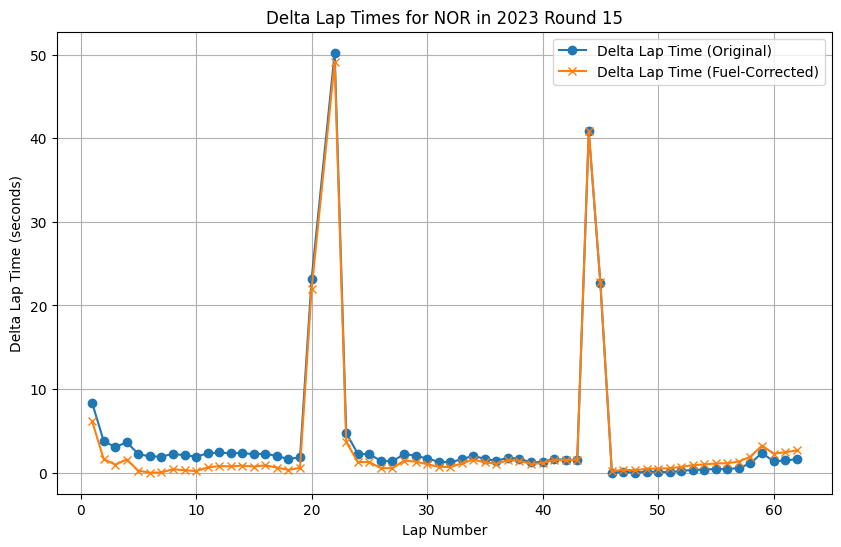

In [26]:
import matplotlib.pyplot as plt
import random

# Function to plot delta lap times (difference from fastest lap)
def plot_delta_lap_times(df, year, round_, driver):
    # Apply fuel correction
    race_df = correct_fuel_effect(df, year, round_)
    
    # Filter for the specific driver
    driver_df = race_df[race_df['driver_short'] == driver]
    
    # Calculate the fastest lap time and fastest fuel-corrected lap time
    fastest_lap_time = driver_df['lap_time'].min()
    fastest_fuel_corrected_lap_time = driver_df['fuel_corrected_lap_time'].min()
    
    # Calculate delta lap times
    driver_df['delta_lap_time'] = driver_df['lap_time'] - fastest_lap_time
    driver_df['delta_fuel_corrected_lap_time'] = driver_df['fuel_corrected_lap_time'] - fastest_fuel_corrected_lap_time
    
    # Plot delta lap times
    plt.figure(figsize=(10, 6))
    plt.plot(driver_df['lap_num'], driver_df['delta_lap_time'], label='Delta Lap Time (Original)', marker='o')
    plt.plot(driver_df['lap_num'], driver_df['delta_fuel_corrected_lap_time'], label='Delta Lap Time (Fuel-Corrected)', marker='x')
    
    # Add labels and title
    plt.xlabel('Lap Number')
    plt.ylabel('Delta Lap Time (seconds)')
    plt.title(f'Delta Lap Times for {driver} in {year} Round {round_}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Select a random race and driver
def select_random_race_and_driver(df):
    # Get unique races
    unique_races = df[['year', 'round']].drop_duplicates()
    
    # Select a random race
    random_race = unique_races.sample(1).iloc[0]
    year = random_race['year']
    round_ = random_race['round']
    
    # Get drivers in the selected race
    drivers_in_race = df[(df['year'] == year) & (df['round'] == round_)]['driver_short'].unique()
    
    # Select a random driver
    driver = random.choice(drivers_in_race)
    
    return year, round_, driver

# Example usage
df = create_dataframe()

# Select a random race and driver
year, round_, driver = select_random_race_and_driver(df)
print(f"Selected Race: {year} Round {round_}, Driver: {driver}")

# Plot delta lap times
plot_delta_lap_times(df, year, round_, driver)